In [122]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import numpy as np
import random
import torch
from pytorch3d import transforms
import math
from linguamechanica.kinematics import DifferentiableOpenChainMechanism
from linguamechanica.kinematics import UrdfRobotLibrary

In [156]:
error_done_threshold = 1e-3
weights = torch.Tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda()
urdf_robot = UrdfRobotLibrary.dobot_cr5()
chain_index = 1
used_open_chain = urdf_robot.extract_open_chains(0.3)[chain_index].to(weights.device)
thetas_count = used_open_chain.screws.shape[0]
pose_count = 6
on_manifold_count = (9 * 2) + ( 2 * thetas_count)
batch_size = 1024

In [157]:
used_open_chain.screws

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00],
        [ 1.4700e-01, -5.3996e-07, -2.3803e-09, -3.6732e-06, -1.0000e+00,
          1.3644e-11]], device='cuda:0')

In [158]:
used_open_chain.initial_matrix

tensor([[-3.6732e-06,  0.0000e+00, -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00, -3.6732e-06, -3.6732e-06,  0.0000e+00],
        [-3.6732e-06, -1.0000e+00,  1.3492e-11,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.4700e-01,  1.0000e+00]], device='cuda:0')

In [159]:
thetas = torch.Tensor([[0.0],[0.0],[1.5]]).cuda()
transformation = used_open_chain.forward_transformation(
    thetas
)
pose = transforms.se3_log_map(transformation.get_matrix())
pose

tensor([[-0.1083,  0.0695,  0.1083,  1.2092,  1.2092, -1.2092],
        [-0.1083,  0.0695,  0.1083,  1.2092,  1.2092, -1.2092],
        [-0.0703,  0.1049,  0.1096,  1.1915,  1.1915,  1.1043]],
       device='cuda:0')

In [160]:
used_open_chain = used_open_chain.to(thetas.device)

In [161]:
target_thetas = torch.Tensor([[1.0],[0.0],[0.5]]).cuda()
target_transformation = used_open_chain.forward_transformation(
    target_thetas
)
target_pose = transforms.se3_log_map(target_transformation.get_matrix())
target_pose

tensor([[-0.0773,  0.0870,  0.1150,  1.1177,  1.1177,  0.3366],
        [-0.1083,  0.0695,  0.1083,  1.2092,  1.2092, -1.2092],
        [-0.0890,  0.0761,  0.1146,  1.1232,  1.1232, -0.4472]],
       device='cuda:0')

In [162]:
def compute_error_pose(open_chain, thetas, target_pose):
    #print("compute_error_pose", thetas.shape, target_pose.shape)
    #print("thetas causing nans", thetas)
    current_transformation = open_chain.forward_transformation(thetas)
    target_transformation = transforms.se3_exp_map(target_pose)
    #print("current_transformation")
    #print(current_transformation.get_matrix())
    #print("target_transformation")
    #print(target_transformation)
    current_trans_to_target = current_transformation.compose(
        transforms.Transform3d(matrix=target_transformation).inverse()
    )
    current_trans_to_target = current_trans_to_target.to(thetas.device).get_matrix()
    #print("current_trans_to_target")
    #print(current_trans_to_target)
    error_pose = transforms.se3_log_map(current_trans_to_target)
    return error_pose

In [163]:
compute_error_pose(used_open_chain, thetas, target_pose)

tensor([[ 2.4125e-09, -1.0885e-08,  1.7733e-08,  9.1252e-01, -4.9851e-01,
         -9.1252e-01],
        [-1.4901e-08,  1.8626e-09, -5.6969e-15, -8.1887e-08,  5.9598e-08,
          8.1887e-08],
        [-1.8561e-08,  4.7160e-08, -2.9986e-08, -5.6182e-01,  8.7497e-01,
          9.1252e-01]], device='cuda:0')

In [164]:
#def force_parameters_within_bounds(thetas):
#    thetas[thetas >  math.pi] -= 2.0 * torch.pi
#    thetas[thetas < -math.pi] += 2.0 * torch.pi
#    return thetas

In [165]:
def compute_reward(thetas, target_pose, weights, error_done_threshold, open_chain):
    if len(thetas.shape) == 1:
        thetas = thetas.unsqueeze(0)
    if len(target_pose.shape) == 1:
        target_pose = target_pose.unsqueeze(0)
    open_chain = open_chain.to(thetas.device)
    #print("!!!!!!!!!!!!!!!!!!!!!")
    #print("thetas", thetas)
    #print("target_pose", target_pose.shape)
    #print("target_pose", target_pose)
    #print("!!!!!!!!!!!!!!!!!!!!!")
    error_pose = compute_error_pose(
        open_chain, thetas, target_pose
    )
    weights = weights.to(thetas.device)
    pose_error = DifferentiableOpenChainMechanism.compute_weighted_error(
        error_pose, weights
    )
    done = pose_error < error_done_threshold
    reward = - pose_error
    return reward, done

In [166]:
angles = torch.Tensor([0.1, -0.1, 0.2, -0.2])
angles_sin = angles.sin()
angles_cos = angles.cos()
torch.atan2(angles_sin, angles_cos) - angles

tensor([0., 0., 0., 0.])

In [167]:
def _step(self, tensordict):
    thetas = torch.atan2(tensordict["thetas_sin"], tensordict["thetas_cos"])
    theta_deltas = tensordict["action"]
    #print("thetas", thetas.shape)
    #print("theta_deltas", theta_deltas.shape)
    theta_deltas_sin, theta_deltas_cos = None, None
    if len(theta_deltas.shape) == 2:
        theta_deltas_sin = theta_deltas[:, 0:1]
        theta_deltas_cos = theta_deltas[:, 1:2]
    else:
        theta_deltas_sin = theta_deltas[0]
        theta_deltas_cos = theta_deltas[1]
    theta_deltas = torch.atan2(theta_deltas_sin, theta_deltas_cos)
    
    #print("theta_deltas", theta_deltas.shape)
    #print("thetas", thetas.shape)
    #max_theta_deltas = tensordict["params", "max_theta_deltas"]
    #print(thetas.shape, theta_deltas.shape)
    new_thetas = thetas + (theta_deltas * 1.000)
    #new_thetas = new_thetas.clamp(-max_theta_deltas, max_theta_deltas)
    target_pose = tensordict["target_pose"]
    #print("target_pose in _step", target_pose)
    #print("STEP", f"Target: {target_pose}", f"Thetas: {thetas}", f"New Thetas: {new_thetas}")
    #TODO: I have no idea if this is a good idea or not
    #new_thetas = force_parameters_within_bounds(new_thetas)
    #print("----------------------------")
    #print("new_thetas.shape", new_thetas.shape)
    #print("target_pose", target_pose)
    #print("weights.shape", weights.shape)
    #print("----------------------------")
    reward, done = compute_reward(new_thetas, target_pose, weights, error_done_threshold, self.open_chain)
    done = torch.zeros_like(reward, dtype=torch.bool)
    out = TensorDict(
        {
            "next": {
                "thetas_sin": new_thetas.sin(),
                "thetas_cos": new_thetas.cos(),
                "target_pose": target_pose,
                "params": tensordict["params"],
                "reward": reward,
                "done": done,
            }
        },
        tensordict.shape,
    )
    return out

In [168]:
def uniformly_sample_parameters_within_constraints(open_chain, batch_size):
    samples = []
    for sample_idx in range(batch_size):
        coordinates = []
        for i in range(len(open_chain.joint_limits)):
            # TODO: check if unconstrained works
            coordinates.append(
                random.uniform(
                    open_chain.joint_limits[i][0],
                    open_chain.joint_limits[i][1],
                )
            )
        samples.append(torch.Tensor(coordinates).unsqueeze(0))
    return torch.cat(samples, 0)


In [169]:
def generate_random_target_pose(target_thetas, open_chain):
    if len(target_thetas.shape) == 1:
        target_thetas = target_thetas.unsqueeze(0)
    open_chain = open_chain.to(target_thetas.device)
    target_transformation = open_chain.forward_transformation(
        target_thetas
    )
    target_pose = transforms.se3_log_map(
        target_transformation.get_matrix()
    )
    if target_thetas.shape[0] == 1:
        target_thetas = target_thetas.squeeze(0)
    #print("generate_random_target_pose", target_pose)
    return target_pose

In [170]:
def _reset(self, tensordict):
    if tensordict is None or tensordict.is_empty():
        # if no tensordict is passed, we generate a single set of hyperparameters
        # Otherwise, we assume that the input tensordict contains all the relevant
        # parameters to get started.
        tensordict = self.gen_params(batch_size=self.batch_size)
    batch_size = 1 if len(tensordict.shape) == 0 else tensordict.shape[0]
    thetas = uniformly_sample_parameters_within_constraints(self.open_chain, batch_size).to(device=self.device)
    if batch_size == 1:
        thetas = thetas.squeeze(0)    
    #thetas = force_parameters_within_bounds(thetas)
    #TODO: randommize this better
    target_thetas = thetas + torch.randn(thetas.shape).to(self.device)
    #target_thetas = force_parameters_within_bounds(target_thetas)
    target_pose   = generate_random_target_pose(target_thetas, self.open_chain)
    if batch_size == 1:
        target_pose = target_pose.squeeze(0)
    #print("target_pose.shape", target_pose.shape)
    out = TensorDict(
        {
            "thetas_sin": thetas.sin(),
            "thetas_cos": thetas.cos(),
            "target_pose": target_pose,
            "params": tensordict["params"],
        },
        batch_size=tensordict.shape,
    )
    return out

In [171]:
def _make_spec(self, td_params):
    # Under the hood, this will populate self.output_spec["observation"]
    self.observation_spec = CompositeSpec(
        thetas_sin=BoundedTensorSpec(
            minimum=-torch.ones(thetas_count),# * torch.pi,
            maximum= torch.ones(thetas_count),# * torch.pi,
            shape=(thetas_count),
            dtype=torch.float32,
        ),
        thetas_cos=BoundedTensorSpec(
            minimum=-torch.ones(thetas_count),# * torch.pi,
            maximum= torch.ones(thetas_count),# * torch.pi,
            shape=(thetas_count),
            dtype=torch.float32,
        ),
        #TODO: bounds are wrong. They need to be the ones in the robot constraints
        target_pose=BoundedTensorSpec(
            minimum=-torch.ones(pose_count) * 10000.0,
            maximum= torch.ones(pose_count) * 10000.0,
            shape=(pose_count),
            dtype=torch.float32,
        ),
        # we need to add the "params" to the observation specs, as we want
        # to pass it at each step during a rollout
        params=make_composite_from_td(td_params["params"]),
        shape=(),
    )
    # since the environment is stateless, we expect the previous output as input.
    # For this, EnvBase expects some state_spec to be available
    self.state_spec = self.observation_spec.clone()
    # action-spec will be automatically wrapped in input_spec when
    # `self.action_spec = spec` will be called supported
    #TODO: bounds are wrong
    self.action_spec = BoundedTensorSpec(
        minimum=-torch.ones(thetas_count * 2),# * 100000.0,
        maximum=+torch.ones(thetas_count * 2),# * 100000.0,
        shape=(thetas_count * 2),
        dtype=torch.float32,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))


def make_composite_from_td(td):
    # custom funtion to convert a tensordict in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

In [172]:
def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng

In [173]:
def gen_params(batch_size=None) -> TensorDictBase:
    if batch_size is None:
        batch_size = []
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "max_theta_deltas": torch.ones(thetas_count) * torch.pi,
                },
                [],
            )
        },
        [],
    )
    if batch_size:
        td = td.expand(batch_size).contiguous()
    return td

In [174]:
class InverseKinematicsEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, open_chain=None, td_params=None, seed=None, device="cpu"):
        super().__init__()
        if td_params is None:
            td_params = self.gen_params()
        self.open_chain = open_chain
        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = _step#staticmethod(_step)
    _set_seed = _set_seed

In [175]:
env = InverseKinematicsEnv(open_chain=used_open_chain)
check_env_specs(env)

check_env_specs succeeded!


We can have a look at our specs to have a visual representation of the environment
signature:




In [176]:
print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

observation_spec: CompositeSpec(
    thetas_sin: BoundedTensorSpec(
        shape=torch.Size([2]),
        space=ContinuousBox(
            minimum=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, contiguous=True), 
            maximum=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    thetas_cos: BoundedTensorSpec(
        shape=torch.Size([2]),
        space=ContinuousBox(
            minimum=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, contiguous=True), 
            maximum=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    target_pose: BoundedTensorSpec(
        shape=torch.Size([6]),
        space=ContinuousBox(
            minimum=Tensor(shape=torch.Size([6]), device=cpu, dtype=torch.float32, contiguous=True), 
            maxim

We can execute a couple of commands too to check that the output structure
matches what is expected.



In [177]:
td = env.reset()
print("reset tensordict", td)

reset tensordict TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                max_theta_deltas: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=cpu,
            is_shared=False),
        target_pose: Tensor(shape=torch.Size([6]), device=cpu, dtype=torch.float32, is_shared=False),
        thetas_cos: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False),
        thetas_sin: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


We can run the :func:`env.rand_step` to generate
an action randomly from the ``action_spec`` domain. A tensordict containing
the hyperparams and the current state **must** be passed since our
environment is stateless. In stateful contexts, ``env.rand_step()`` works
perfectly too.




In [178]:
td = env.rand_step(td)
print("random step tensordict", td)

random step tensordict TensorDict(
    fields={
        action: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        max_theta_deltas: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([]),
                    device=cpu,
                    is_shared=False),
                reward: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                target_pose: Tensor(shape=torch.Size([6]), device=cpu, dtype=torch.float32, is_shared=False),
                thetas_cos: Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.float32, is_s

In [179]:
def get_pose_and_error_pose(thetas, target_pose, open_chain):
    open_chain = open_chain.to(thetas.device)
    error_pose = compute_error_pose(open_chain, thetas, target_pose)
    transformation = open_chain.forward_transformation(thetas)
    pose = transforms.se3_log_map(transformation.get_matrix())
    return pose, error_pose

In [212]:
'''
transformed_env = TransformedEnv(
    env,
    # Unsqueezes the observations that we will concatenate
    UnsqueezeTransform(
        unsqueeze_dim=0,
        in_keys=["thetas", "target_pose"],
        in_keys_inv=["thetas", "target_pose"],
    ),
)
'''
transformed_env = TransformedEnv(env)
'''
class OnManifodErrorTransform(Transform):
    def __init__(self, in_keys, out_keys, open_chain):
        super().__init__(in_keys, out_keys)
        self.open_chain = open_chain
        
    def _apply_transform(self, obs: torch.Tensor) -> None:
        #print("-----------------")
        #print("obs.shape", obs.shape)
        #print("obs", obs)
        thetas_sin, thetas_cos, target_pose = None, None, None
        if len(obs.shape) == 1:
            target_pose = obs[:-thetas_count*2].unsqueeze(0)
            thetas_cos = obs[obs.shape[0] - (thetas_count*2):obs.shape[0] - thetas_count].unsqueeze(0)
            thetas_sin = obs[obs.shape[0] - thetas_count:].unsqueeze(0)            
        elif len(obs.shape) == 2:
            target_pose = obs[:,:-thetas_count*2]
            thetas_cos = obs[:,obs.shape[1] - (thetas_count*2):obs.shape[1] - thetas_count]
            thetas_sin = obs[:,obs.shape[1] - thetas_count:]
        #print(thetas_cos)
        #print(thetas_sin)
        #print("thetas.shape", thetas.shape)
        #print("target_pose.shape", target_pose.shape)
        thetas = torch.atan2(thetas_sin, thetas_cos)
        #print(thetas)
        pose, error_pose = get_pose_and_error_pose(thetas, target_pose, self.open_chain)
        # pose decomposition
        pose_linear =  pose[:, :3]
        pose_angular_cos =  pose[:, 3:].cos()
        pose_angular_sin =  pose[:, 3:].sin()
        # error pose decomposition 
        error_pose_linear =  error_pose[:, :3]
        error_pose_angular_cos =  error_pose[:, 3:].cos()
        error_pose_angular_sin =  error_pose[:, 3:].sin()
        
        #print("---------------------")
        #print("obs", obs)
        #print("error_pose", error_pose)
        #print("pose", pose)
        #print("target_pose", target_pose)
        #print("---------------------")
        
        #manifold_error = torch.cat([pose_linear, pose_angular_cos, pose_angular_sin, error_pose_linear, error_pose_angular_cos, error_pose_angular_sin, thetas_sin, thetas_cos], 1)
        manifold_error = torch.cat([pose_linear, pose_angular_cos , pose_angular_sin, error_pose_linear, error_pose_angular_cos, error_pose_angular_sin, thetas_cos, thetas_sin], 1)        
        #print(manifold_error.shape, on_manifold_count)
        #print("manifold_error", manifold_error)
        #print("obs", obs.shape, manifold_error.shape)
        if len(obs.shape) == 1:
            return manifold_error.squeeze(0)
        else:
            #print("---------------------")
            #print("error_pose", error_pose.abs()[:, :])
            #print("error_pose max", error_pose[:,-1].max().item())
            #print("error_pose min", error_pose[:,-1].min().item())
            #print("---------------------")
            return manifold_error

    # _apply_to_composite will execute the observation spec transform across all
    # in_keys/out_keys pairs and write the result in the observation_spec which
    # is of type ``Composite``
        
    #TODO minimum and maximum are incorrect!!
    @_apply_to_composite
    def transform_observation_spec(self, observation_spec):
        return BoundedTensorSpec(
            minimum=-10000,
            maximum=10000,
            shape=(on_manifold_count),
            dtype=observation_spec.dtype,
            device=observation_spec.device,
        )
        
cat_transform = CatTensors(
    in_keys=["thetas_sin", "thetas_cos", "target_pose"], dim=-1, out_key="observation", del_keys=False
)
transformed_env.append_transform(cat_transform)
on_manifold_error = OnManifodErrorTransform(in_keys=["observation"], 
                                            out_keys=["on_manifold_error"],
                                            open_chain=used_open_chain)
transformed_env.append_transform(on_manifold_error)
'''

'\nclass OnManifodErrorTransform(Transform):\n    def __init__(self, in_keys, out_keys, open_chain):\n        super().__init__(in_keys, out_keys)\n        self.open_chain = open_chain\n        \n    def _apply_transform(self, obs: torch.Tensor) -> None:\n        #print("-----------------")\n        #print("obs.shape", obs.shape)\n        #print("obs", obs)\n        thetas_sin, thetas_cos, target_pose = None, None, None\n        if len(obs.shape) == 1:\n            target_pose = obs[:-thetas_count*2].unsqueeze(0)\n            thetas_cos = obs[obs.shape[0] - (thetas_count*2):obs.shape[0] - thetas_count].unsqueeze(0)\n            thetas_sin = obs[obs.shape[0] - thetas_count:].unsqueeze(0)            \n        elif len(obs.shape) == 2:\n            target_pose = obs[:,:-thetas_count*2]\n            thetas_cos = obs[:,obs.shape[1] - (thetas_count*2):obs.shape[1] - thetas_count]\n            thetas_sin = obs[:,obs.shape[1] - thetas_count:]\n        #print(thetas_cos)\n        #print(thetas_s

In [213]:
#cat_transform = CatTensors(
#    in_keys=["sin", "cos", "thdot"], dim=-1, out_key="observation", del_keys=False
#)
#transformed_env.append_transform(cat_transform)

Once more, let us check that our env specs match what is received:



In [214]:
check_env_specs(transformed_env)

check_env_specs succeeded!


## Executing a rollout

Executing a rollout is a succession of simple steps:

* reset the environment
* while some condition is not met:

  * compute an action given a policy
  * execute a step given this action
  * collect the data
  * make a MDP step

* gather the data and return

These operations have been convinently wrapped in the :func:`EnvBase.rollout`
method, from which we provide a simplified version here below.



In [215]:
def simple_rollout(steps=100):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = transformed_env.reset()
    for i in range(steps):
        _data["action"] = transformed_env.action_spec.rand()
        _data = transformed_env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(100))

data from rollout: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([100, 4]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        max_theta_deltas: Tensor(shape=torch.Size([100, 2]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([100]),
                    device=None,
                    is_shared=False),
                reward: Tensor(shape=torch.Size([100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                target_pose: Tensor(shape=torch.Size([100, 6]), device=cpu, dtype=torch.float32, is_shared=False),
                thetas_cos: Tensor(shape=torch.Size([100, 2]), de

## Batching computations

The last unexplored end of our tutorial is the ability that we have to
batch computations in TorchRL. Because our environment does not
make any assumptions regarding the input data shape, we can seamlessly
execute it over batches of data. Even better: for non-batch-locked
environments such as our Pendulum, we can change the batch size on the fly
without recreating the env.
To do this, we just generate parameters with the desired shape.




In [216]:
batch_size = 10  # number of environments to be executed in batch
td = transformed_env.reset(transformed_env.gen_params(batch_size=[batch_size]))
print(f"reset (batch size of {batch_size})", td)
td = transformed_env.rand_step(td)
print(f"rand step (batch size of {batch_size})", td)

reset (batch size of 10) TensorDict(
    fields={
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        params: TensorDict(
            fields={
                max_theta_deltas: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([10]),
            device=None,
            is_shared=False),
        target_pose: Tensor(shape=torch.Size([10, 6]), device=cpu, dtype=torch.float32, is_shared=False),
        thetas_cos: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        thetas_sin: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([10]),
    device=None,
    is_shared=False)
rand step (batch size of 10) TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 4]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1])

executing a rollout with a batch of data requires us to reset the env
out of the rollout function, since we need to define the batch_size
dynamically and this is not supported by :func:`EnvBase.rollout`:




In [217]:
rollout = transformed_env.rollout(
    3,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=transformed_env.reset(transformed_env.gen_params(batch_size=[batch_size])),
)
print("rollout of len 3 (batch size of 10):", rollout)

rollout of len 3 (batch size of 10): TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 3, 4]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                params: TensorDict(
                    fields={
                        max_theta_deltas: Tensor(shape=torch.Size([10, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([10, 3]),
                    device=None,
                    is_shared=False),
                reward: Tensor(shape=torch.Size([10, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                target_pose: Tensor(shape=torch.Size([10, 3, 6]), device=cpu, dtype=torch.float32, is_shared=False),
                thetas_cos: Tenso

## Training a simple policy

In this example, we will train a simple policy using the reward as a
differentiable objective (i.e. a negative loss).
We will take advantage of the fact that our dynamic system is fully
differentiable to backpropagate through the trajectory return and adjust the
weights of our policy to maximise this value directly. Of course, in many
settings many of the assumptions we make do not hold, such as
differentiability of the system and full access to the underlying mechanics.

Still, this is a very simple example that showcases how a training loop can
be coded with a custom environment in TorchRL.

Let us first write the policy network:




In [301]:
torch.manual_seed(0)
transformed_env.set_seed(0)

net = nn.Sequential(
    nn.Linear(in_features=1, out_features=4, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=4, out_features=thetas_count, bias=True)
).cuda()

import torch.nn.functional as F

class DummyActor(nn.Module):
    def __init__(
        self,
    ):
        super(DummyActor, self).__init__()
        local_on_manifold_count = on_manifold_count
        weights = 128
        self.fc1 = nn.Linear(in_features=local_on_manifold_count, out_features=weights, bias=True)
        self.fc2 = nn.Linear(in_features=weights+local_on_manifold_count, out_features=weights, bias=True)
        self.fc3 = nn.Linear(in_features=weights+local_on_manifold_count, out_features=weights, bias=True)
        self.fc4 = nn.Linear(in_features=weights+local_on_manifold_count, out_features=weights, bias=True)
        self.fc5 = nn.Linear(in_features=weights+local_on_manifold_count, out_features=weights, bias=True)
        self.fc6 = nn.Linear(in_features=weights+local_on_manifold_count, out_features=weights, bias=True)
        self.fc_cos = nn.Linear(in_features=weights+local_on_manifold_count, out_features=1, bias=True)
        self.fc_sin = nn.Linear(in_features=weights+local_on_manifold_count, out_features=1, bias=True)

    def forward(self, thetas_sin, thetas_cos, target_pose):
        #print(thetas_sin)
        #print(thetas_cos)
        #print(target_pose)
        thetas = torch.atan2(thetas_sin, thetas_cos)
        pose, error_pose = get_pose_and_error_pose(thetas, target_pose, used_open_chain)
        #print(error_pose)
        #print("state", thetas_sin.shape, thetas_cos.shape, target_pose.shape)
        # pose decomposition
        pose_linear =  pose[:, :3]
        pose_angular_cos =  pose[:, 3:].cos()
        pose_angular_sin =  pose[:, 3:].sin()
        # error pose decomposition 
        error_pose_linear =  error_pose[:, :3]
        error_pose_angular_cos =  error_pose[:, 3:].cos()
        error_pose_angular_sin =  error_pose[:, 3:].sin()
        
        manifold_error = torch.cat([pose_linear, pose_angular_cos , pose_angular_sin, error_pose_linear, error_pose_angular_cos, error_pose_angular_sin, thetas_cos, thetas_sin], 1)      
        #manifold_error = torch.cat([ error_pose_linear, error_pose_angular_cos, error_pose_angular_sin], 1)#, thetas_cos, thetas_sin], 1)      
        #print(manifold_error.shape, on_manifold_count)
        x = torch.cat([F.tanh(self.fc1(manifold_error)), manifold_error],1)
        x = torch.cat([F.tanh(self.fc2(x)), manifold_error],1)
        x = torch.cat([F.tanh(self.fc3(x)), manifold_error],1)
        x = torch.cat([F.tanh(self.fc4(x)), manifold_error],1)
        x = torch.cat([F.tanh(self.fc5(x)), manifold_error],1)
        x = torch.cat([F.tanh(self.fc6(x)), manifold_error],1)
        cos = self.fc_cos(x).cos()
        sin = self.fc_sin(x).sin()
        return torch.cat([sin, cos], 1)

net = DummyActor().cuda()

and our optimizer:




### Training loop

We will successively:

* generate a trajectory
* sum the rewards
* backpropagate through the graph defined by these operations
* clip the gradient norm and make an optimization step
* repeat

At the end of the training loop, we should have a final reward close to 0
which demonstrates that the pendulum is upward and still as desired.




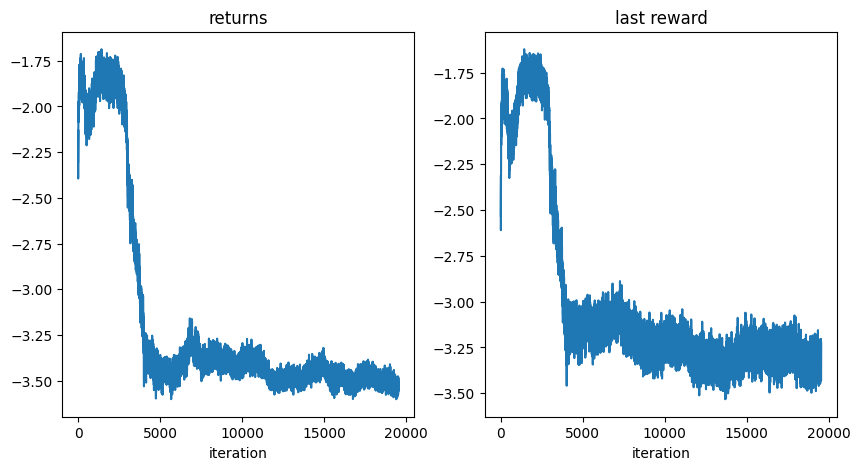

In [302]:
policy = TensorDictModule(
    net,
    in_keys=["thetas_sin", "thetas_cos", "target_pose"],#["on_manifold_error"], #["target_pose"],
    out_keys=["action"],
).cuda()
optim = torch.optim.Adam(policy.parameters(), lr=2e-5)

batch_size = 1024
iterations = 20000_000
pbar = tqdm.tqdm(range(iterations // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, iterations)
logs = defaultdict(list)

# current_env = env 
current_env = transformed_env.cuda()
for _ in pbar:
    init_td = current_env.reset(current_env.gen_params(batch_size=[batch_size])).cuda()
    rollout = current_env.rollout(10, policy, tensordict=init_td, auto_reset=False).cuda()
    #print(rollout)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    is_ipython = "inline" in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    with plt.ion():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(logs["return"])
        plt.title("returns")
        plt.xlabel("iteration")
        plt.subplot(1, 2, 2)
        plt.plot(logs["last_reward"])
        plt.title("last reward")
        plt.xlabel("iteration")
        if is_ipython:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        plt.show()


plot()